# There you will find my code_source for the case study project on German market electricity price forecasting with LSTM by using only 3 months as a training window : 

In [27]:
# First lets get various Python library : 
import pandas as pd # for data
import numpy as np # for Maths
import matplotlib.pyplot as plt # For Plotting
from matplotlib import style # For the plotting style
plt.style.use('fivethirtyeight') # The style
import sklearn as sklearn # For Machine Learning tools  

In [32]:
# Lets now read the various datasets:
price = pd.read_csv('price.xls')
production = pd.read_csv('production.xls')
weather = pd.read_csv('weather.xls')
consumption = pd.read_csv('consumption.xls')
net_import = pd.read_csv('net_imports.xls')
costs = pd.read_csv('costs.xls')

# I'm gonna concatenate the DataFrame so I want to put the same index_name on each : 
net_import.rename(columns = {'Date':'datetime'}, inplace = True)
costs.rename(columns = {'date':'datetime'}, inplace = True)
net_import = net_import.drop_duplicates(subset=["datetime"],keep='first')
# Setting up the Index : 
price.set_index('datetime',inplace = True)
production.set_index('datetime',inplace = True)
weather.set_index('datetime',inplace = True)
net_import.set_index('datetime',inplace = True)
consumption.set_index('datetime',inplace = True)
costs.set_index('datetime',inplace = True)

# We see that the frequency of the costs dataset is different from the frequency of the others and the the price that we want to forecast are available also on a hourly basis.
# So I choose to not use the costs dataframe to forecast the electricity prices. 
costs

,Clean Spark Spread,Clean Dark Spread
datetime,,
2019-01-01,-59.93,-54.42
2019-01-02,-29.74,-24.50
2019-01-03,2.47,7.41
2019-01-04,-6.72,-0.40
2019-01-05,-13.48,-8.28
...,...,...
2022-06-26,-94.95,-5.13
2022-06-27,18.91,103.67
2022-06-28,31.05,117.66


In [38]:
# Lets now create one big dataframe with the various available data: 
feature_dataframe = pd.concat([consumption,production,weather,net_import],axis =1)

# Lets now see the nan values we have : 
feature_dataframe.isna().sum()
# Because there is only few missing values, I will fill them with the last value each time: 
feature_dataframe.isna().sum()

consumption      0
Dam              1
Solar            0
NaturalGas       0
Ror              0
HardCoal         0
Nuclear          0
WindOnshore      0
WindOffshore     0
TEMPERATURE      0
WIND            54
NetImport       24
dtype: int64

In [40]:
# Before filling : 
feature_dataframe.ffill(inplace = True)
feature_dataframe.isna().sum()
# We now have No Nan Values into our dataset

consumption     0
Dam             0
Solar           0
NaturalGas      0
Ror             0
HardCoal        0
Nuclear         0
WindOnshore     0
WindOffshore    0
TEMPERATURE     0
WIND            0
NetImport       0
dtype: int64

In [4]:
feature_dataframe = feature_dataframe[:-24] 

In [42]:
target_dataframe = price

In [44]:
# Here I mannage to notice that there is missing value on the target_dataframe:
difference =  len(feature_dataframe) - len(target_dataframe) 
lenght_may_june_price = len(feature_dataframe[target_dataframe.index[-1]:]) - 1

In [46]:
difference - lenght_may_june_price
# We see that there is 23 missing data.

23

In [48]:
# I mannage to remove them : 
index_list = []
for value in feature_dataframe[:target_dataframe.index[-1]].index:
    if value not in target_dataframe.index:
        index_list.append(value)
for value in index_list:
    feature_dataframe.drop(index = value,inplace = True)

In [50]:
# Now we got a feature_dataframe who have his lenght equal to the lenght of target_dataframe + the lenght of May and June hourly price.
# And a target_dataframe.
lenght_may_june_price -  (len(feature_dataframe) - len(target_dataframe))

0

In [52]:
# Here I cut the datasets to train the model on one year of data only.
target_dataframe = target_dataframe[-2150:]
feature_dataframe = feature_dataframe[-2150-lenght_may_june_price:]

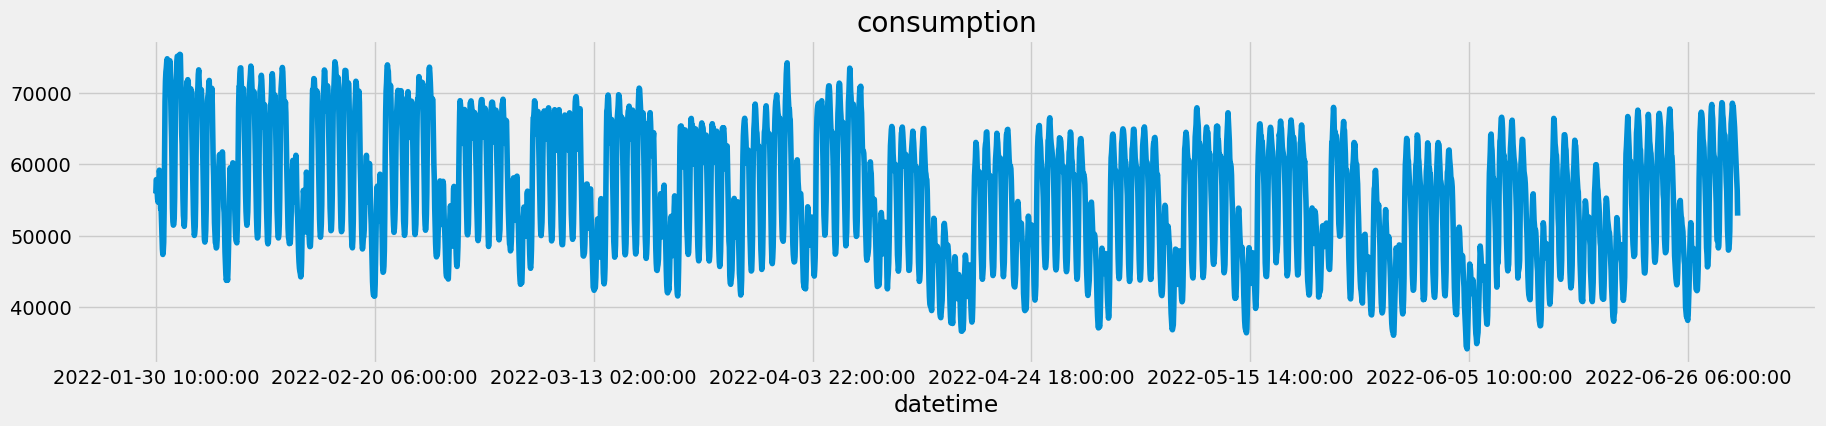

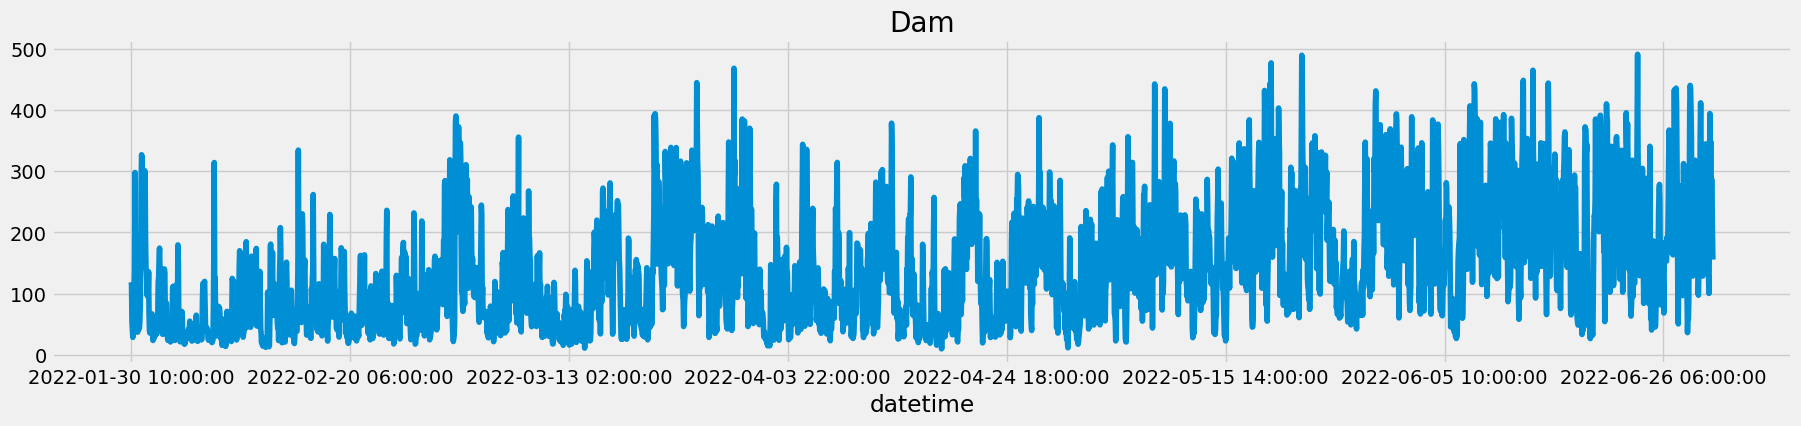

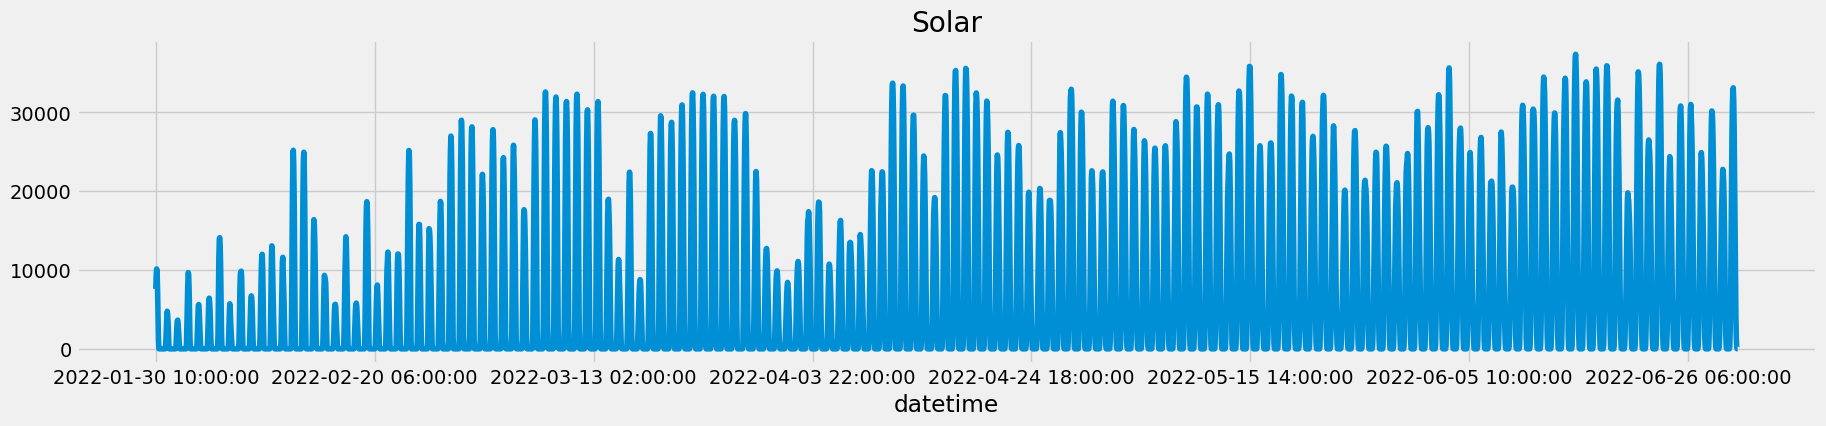

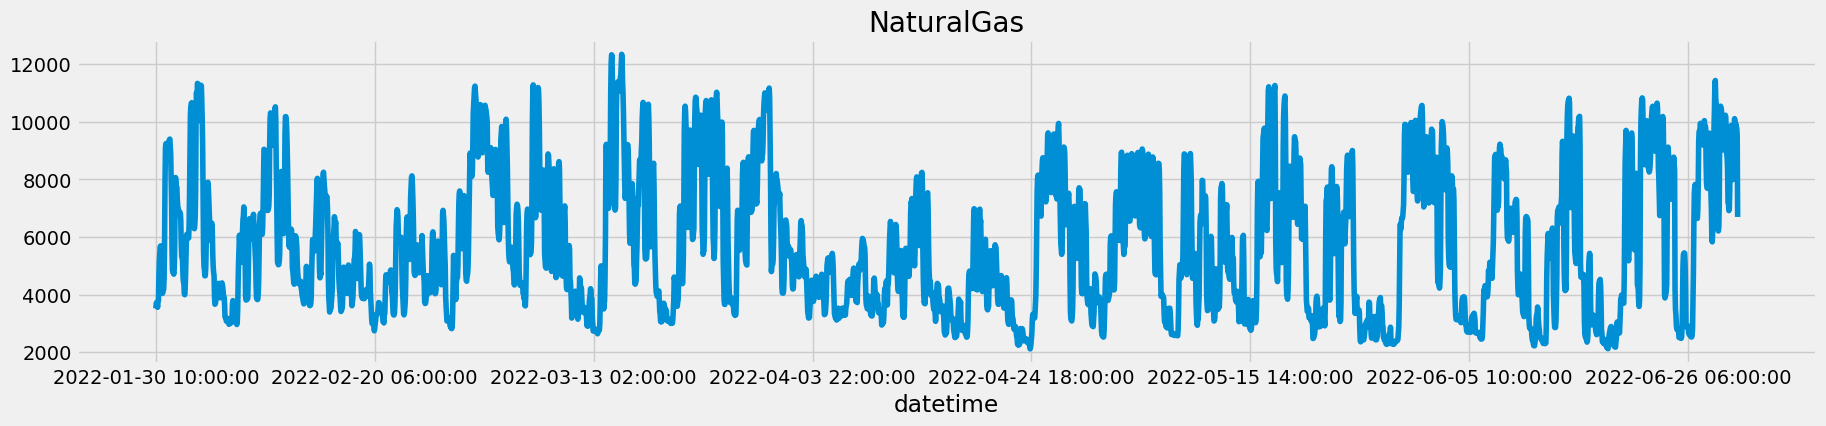

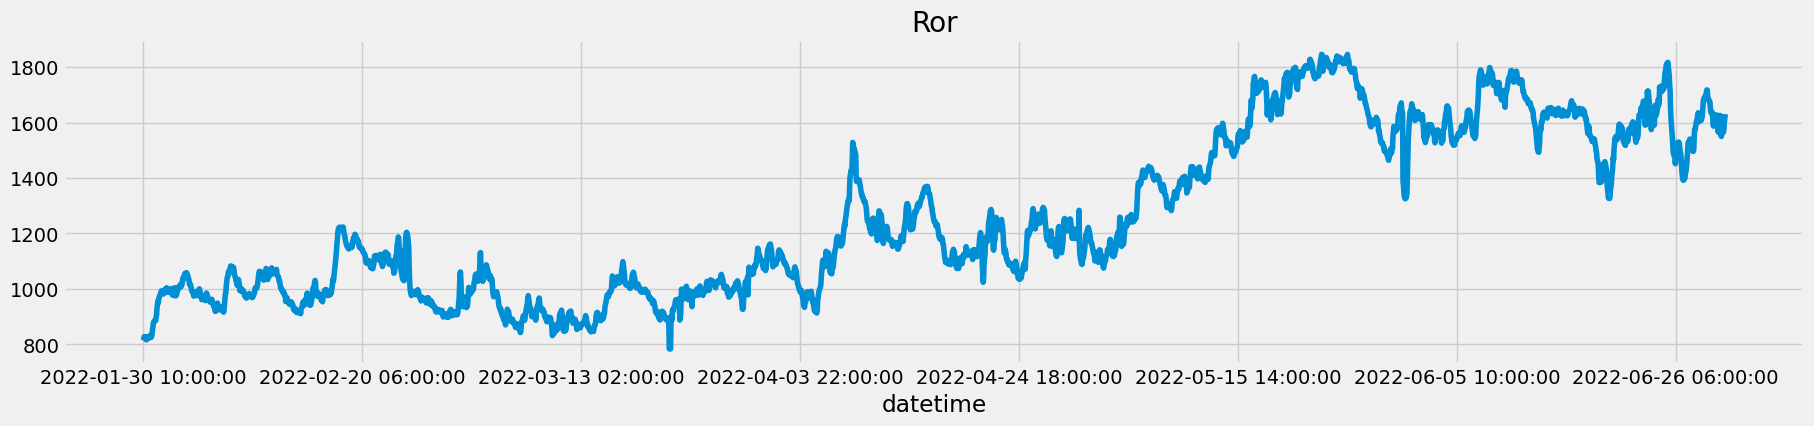

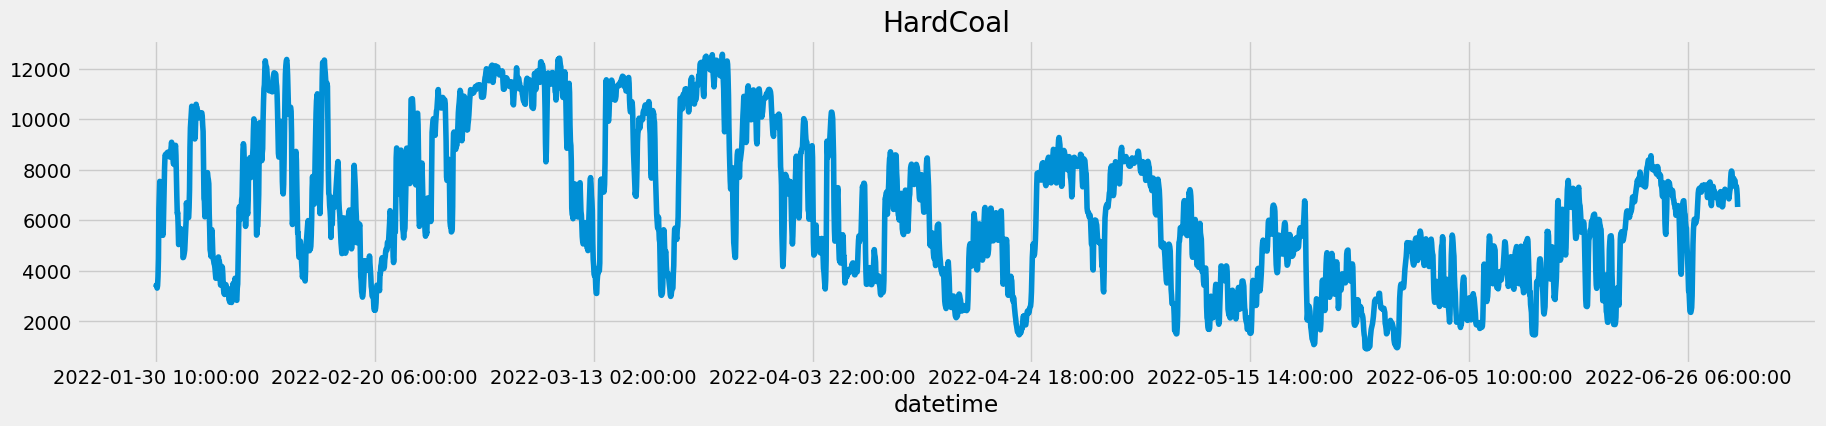

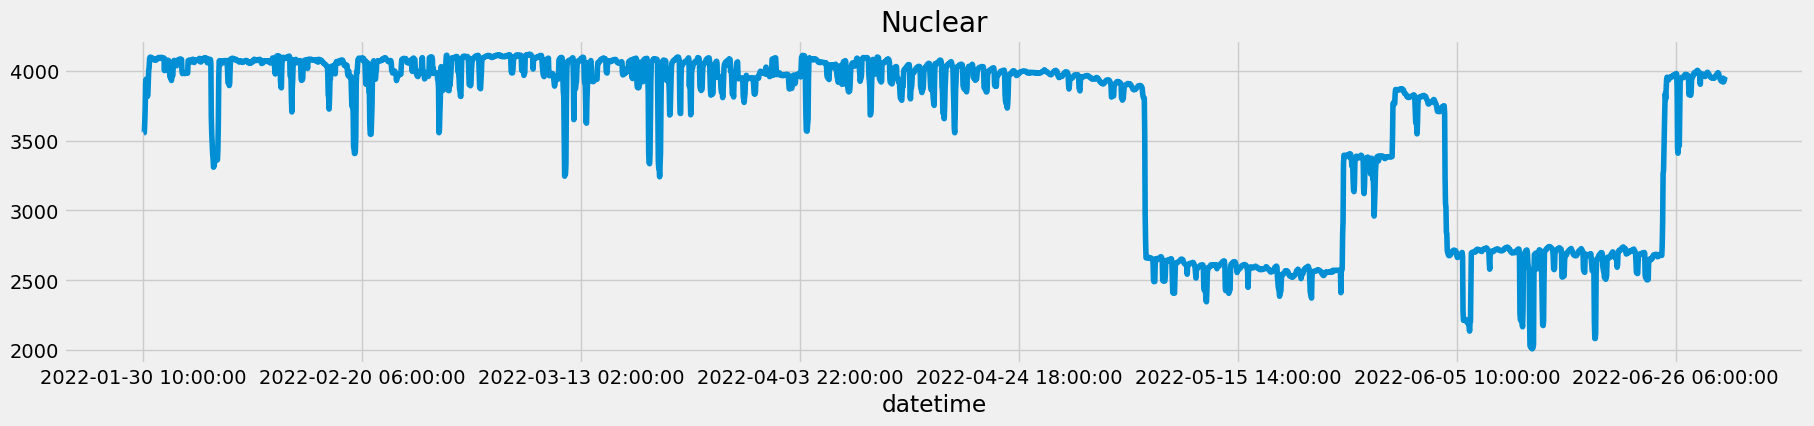

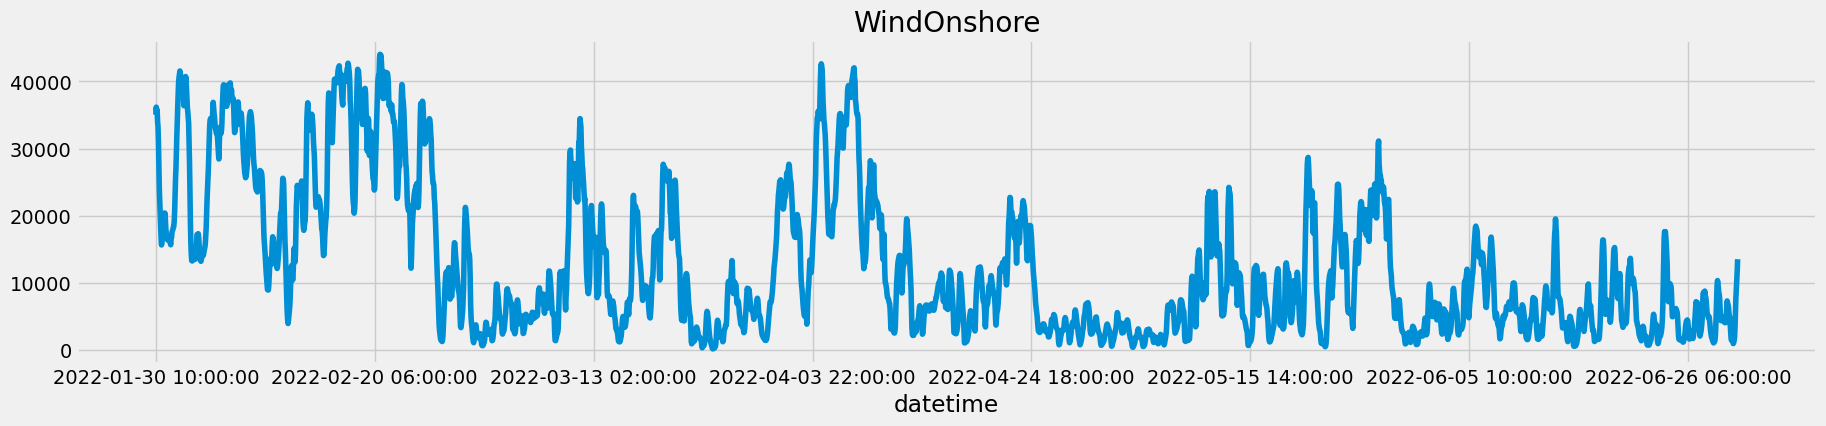

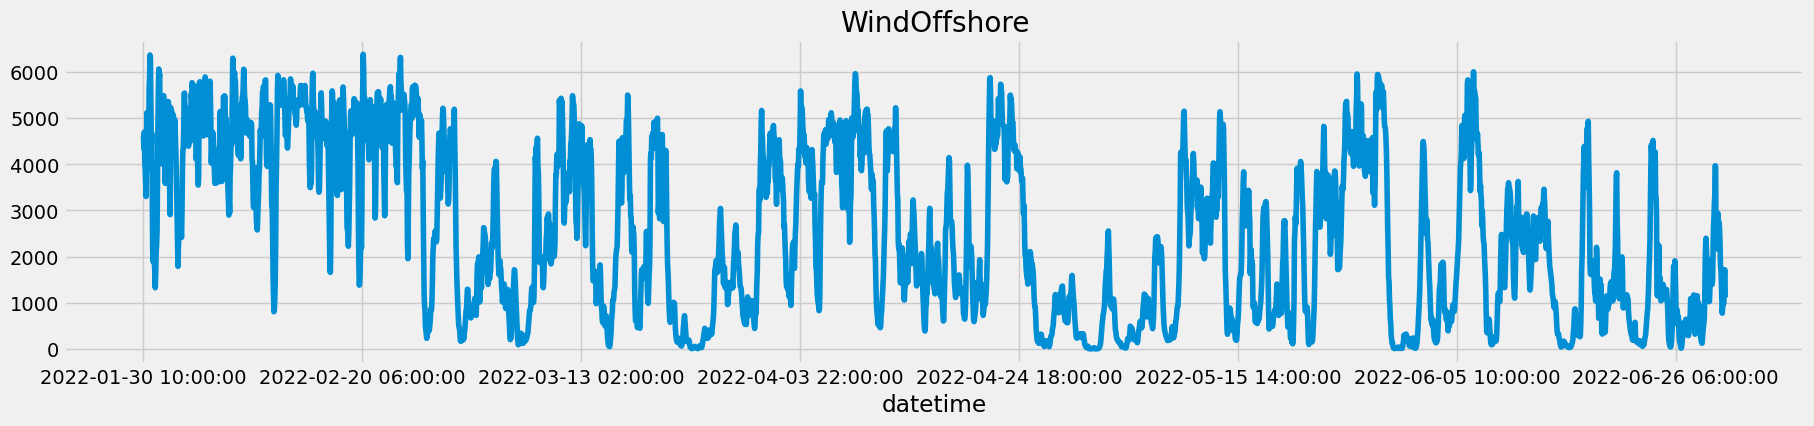

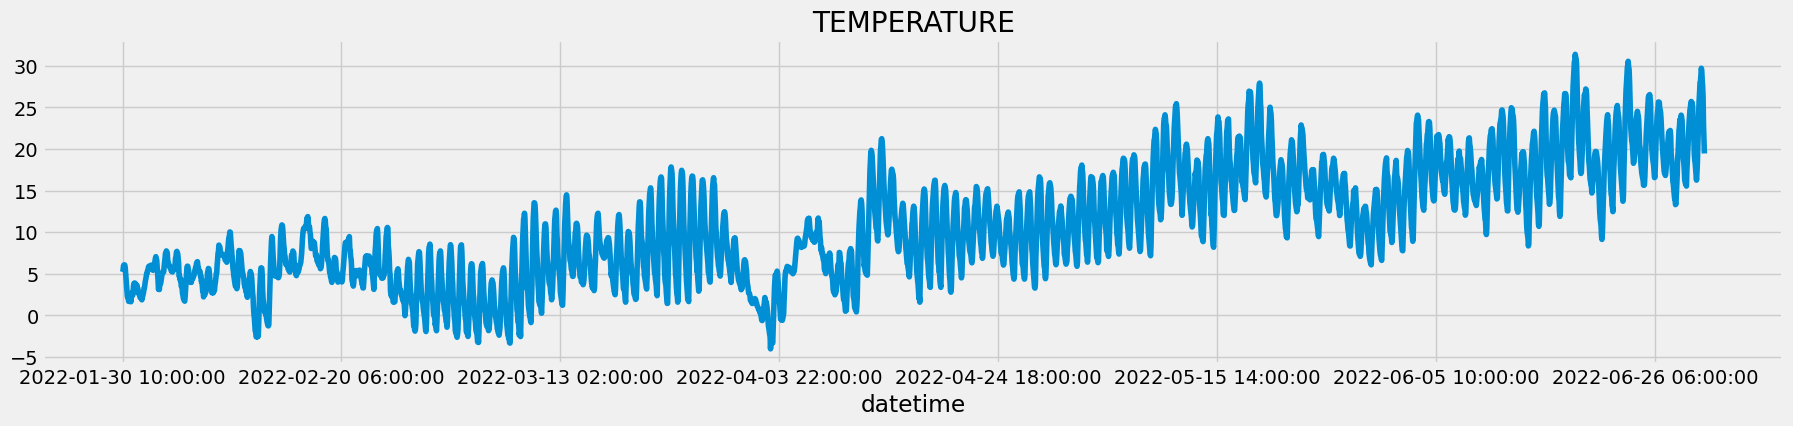

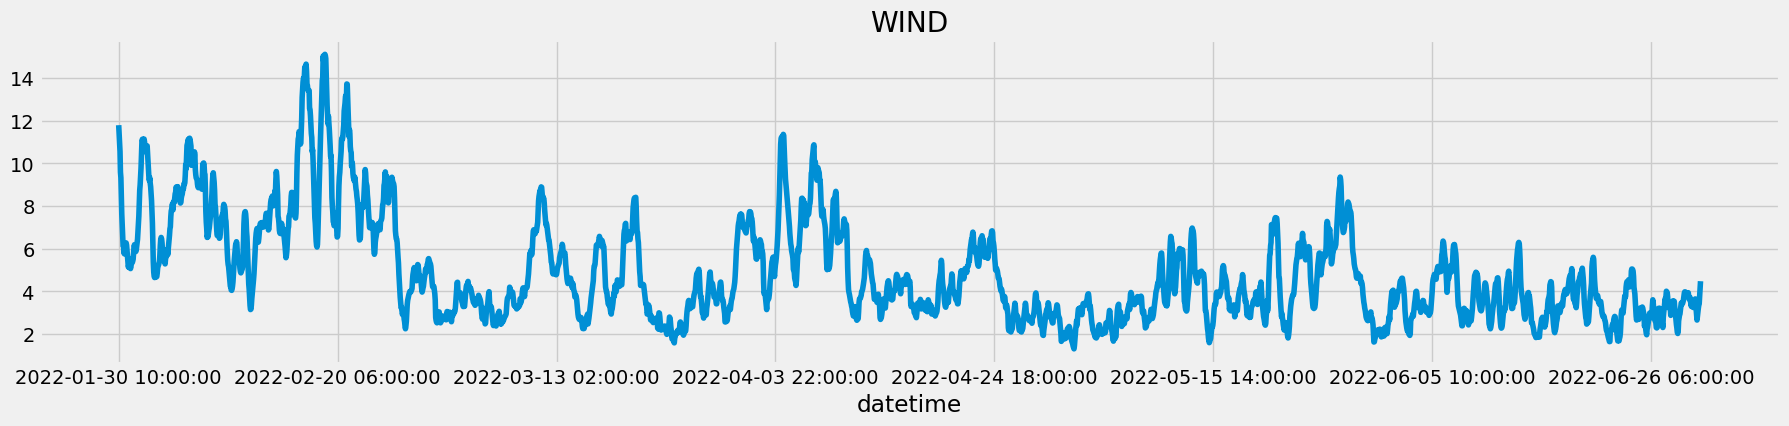

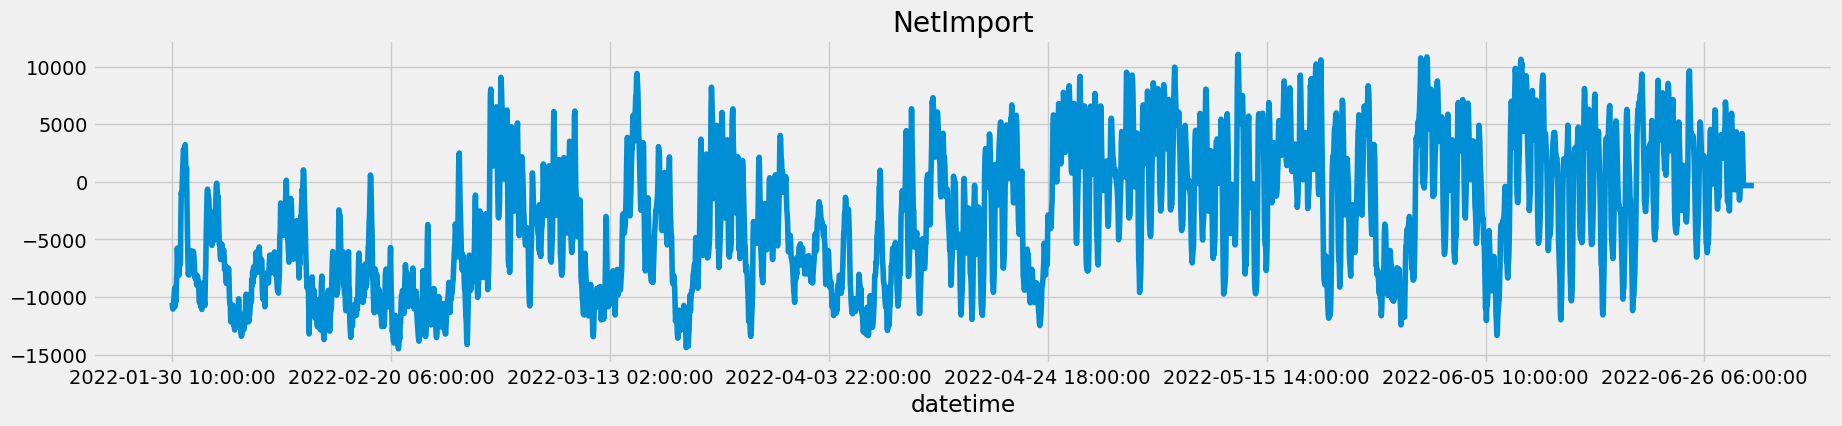

In [54]:
# Lets now vizualize each of the feature and the electricity prices : 
for column in feature_dataframe.columns:
    plt.figure(figsize = (20,4))
    feature_dataframe[column].plot()
    plt.title(column)

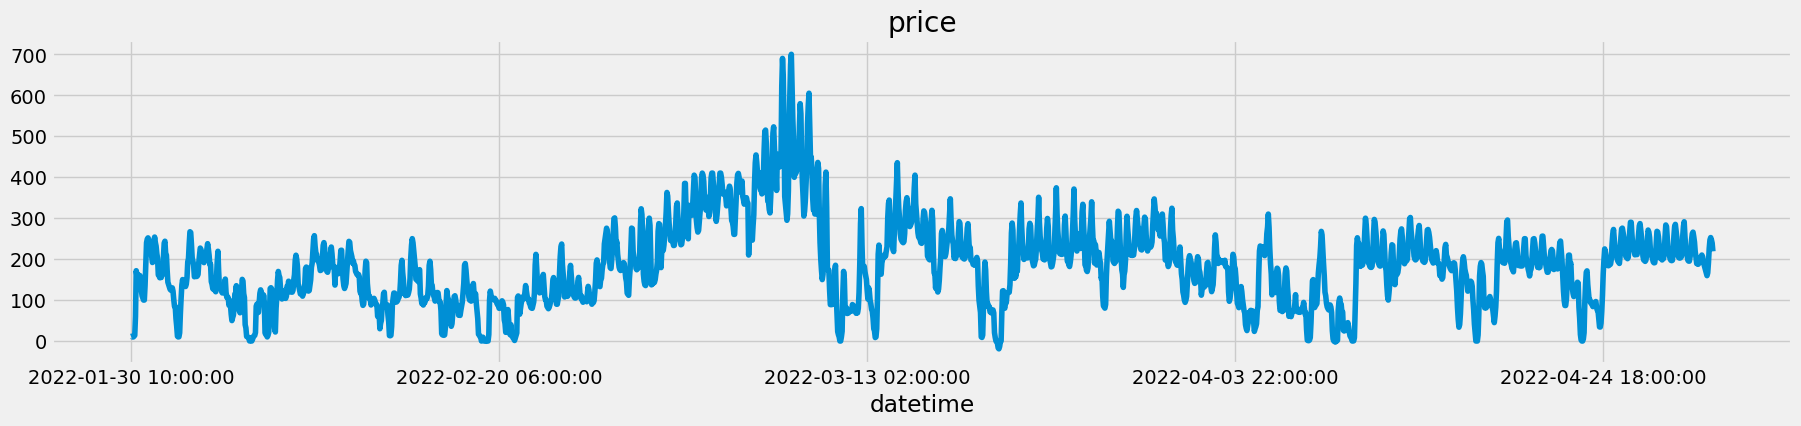

In [56]:
# Lets now vizualize each of the feature and the electricity prices : 
for column in target_dataframe.columns:
    plt.figure(figsize = (20,4))
    target_dataframe[column].plot()
    plt.title(column)

In [58]:
# Lets see the correlation matrix of the dataset : 
# By doing that we can see if there is useless feature (strongly correlated feature to others).
feature_dataframe.corr()
# We see that WindOnshore and WindOffshore are strongly correlated.

,consumption,Dam,Solar,NaturalGas,Ror,HardCoal,Nuclear,WindOnshore,WindOffshore,TEMPERATURE,WIND,NetImport
consumption,1.000000,0.081407,0.344796,0.446412,-0.248737,0.425460,0.216213,0.212009,0.097039,-0.007414,0.270382,-0.108950
Dam,0.081407,1.000000,0.000304,0.406079,0.439792,0.024459,-0.367912,-0.414849,-0.351284,0.421451,-0.391063,0.571011
Solar,0.344796,0.000304,1.000000,-0.172328,0.193015,-0.170172,-0.249621,-0.274999,-0.235998,0.453514,-0.112875,-0.219811
NaturalGas,0.446412,0.406079,-0.172328,1.000000,-0.030944,0.626804,0.133505,-0.343847,-0.370889,-0.023798,-0.356942,0.562232
Ror,-0.248737,0.439792,0.193015,-0.030944,1.000000,-0.562439,-0.767263,-0.320547,-0.227507,0.726029,-0.299926,0.413000
HardCoal,0.425460,0.024459,-0.170172,0.626804,-0.562439,1.000000,0.505959,-0.226838,-0.226748,-0.414028,-0.243778,0.169909
Nuclear,0.216213,-0.367912,-0.249621,0.133505,-0.767263,0.505959,1.000000,0.250490,0.179192,-0.672967,0.219373,-0.291757
WindOnshore,0.212009,-0.414849,-0.274999,-0.343847,-0.320547,-0.226838,0.250490,1.000000,0.738673,-0.340080,0.939339,-0.688714
WindOffshore,0.097039,-0.351284,-0.235998,-0.370889,-0.227507,-0.226748,0.179192,0.738673,1.000000,-0.310181,0.744178,-0.624847
TEMPERATURE,-0.007414,0.421451,0.453514,-0.023798,0.726029,-0.414028,-0.672967,-0.340080,-0.310181,1.000000,-0.277279,0.304787


## To keep only the usefull feature to train the model, I perform a PCA.
To find them, I choose to perform an explainable variance process by doing the PCA.
I want to keep only the feature who can explain the whole variance contained in the feature dataset.

This methodology make sens because as I will use the Data to feed an LSTM neural network algorithm, this model is going to find non-linear
relationship between the features and the price, so keeping the feature who can explain the variance of the available data make sens
and is going to feed the model with meaningfull data.

Because neural network need to be trained with scaled data and because the available data got different scale, I first scale de whole dataset and then run a PCA.
Then I manage to find the smallest number of feature who is able to explain at least 85% of the whole variance.

In [61]:
from sklearn.preprocessing import MinMaxScaler # Importation of the Scaler

# Scaling of the DataFrame:

# Here the use of 2 scaler is important : 
# The first one is for the feature, because I want to have the same scaled feature on the training set and the May and June months.

scaler_feature = MinMaxScaler() 
scaled_dataset_feature = pd.DataFrame(scaler_feature.fit_transform(feature_dataframe))
scaled_dataset_feature.columns = feature_dataframe.columns

# The second one is for the target.
# This is because after predicted the price for may and june, I'm gonna add them to the previous scaled price and then reverse scale the whole price dataset. 
# By doing that I'm sure that the scaler used are robust for the training and to predict the price in May and june.
scaler_pred = MinMaxScaler() 
scaled_dataset_pred = pd.DataFrame(scaler_pred.fit_transform(target_dataframe))
scaled_dataset_pred.columns = target_dataframe.columns

# Because I want to forecast the price for the next hour each time, I perform a shifting on the price value.
# By doing that, we now have a dataframe on wich we can learn the behavior of the price at time T+1 with the data available at time T.
scaled_dataset_pred["price_to_forecast"] = scaled_dataset_pred.price.shift(-1)

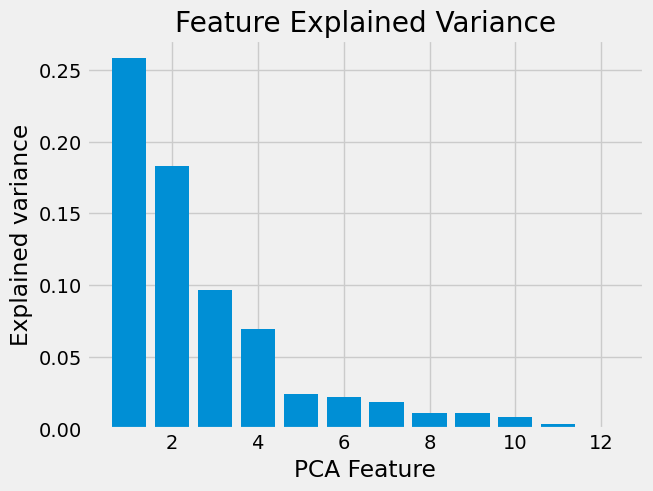

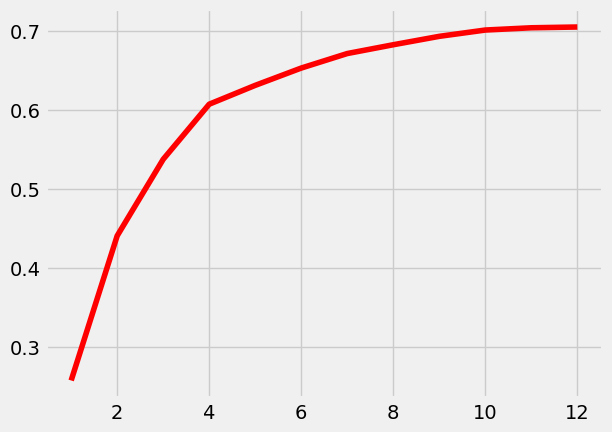

In [63]:
# Library for PCA:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit(scaled_dataset_feature) 
    
    # Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
    
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')

In [65]:
# By simply reading the plot I see that most of the variance is explained by 6 feature only:
# Then I calcul the % ratio of the explained variance from the 6 feature versus the total variance:
Eplained_variance_from_6_feature = np.round(100 * pca.explained_variance_[:6].sum()/ pca.explained_variance_.sum(),2)
print("The 6 feature can explain " + "{}".format(Eplained_variance_from_6_feature) + " % of the total variance.")

The 6 feature can explain 92.64 % of the total variance.


## Then I train the model on these feature only. 
## With this result, we can see that 6 features can explain 92.64 % of the variance.
## So with this setup we manage to reduce the number of feature by 50%, this will improve the training time and remove useless noise in the training data.

In [69]:
# Now that I have found the optimal feature representation of the initial DataFrame, I transform it with the best feature numbers paramater:
pca = PCA(n_components=6)
PCA_Dataset = pd.DataFrame(pca.fit_transform(scaled_dataset_feature))
PCA_Dataset.columns = ["PCA1","PCA2","PCA3","PCA4","PCA5","PCA6"]

# I add the price and the price_to_forecast to create a supervised learning DataFrame : 
# But before I have to cut it: 

PCA_Dataset_train = PCA_Dataset[:len(scaled_dataset_pred)]
PCA_Dataset_train = PCA_Dataset_train.copy()
PCA_Dataset_train["price"] = scaled_dataset_pred.price.values
PCA_Dataset_train["Price_to_forecast"] = scaled_dataset_pred.price_to_forecast.values
PCA_Dataset_test = PCA_Dataset[len(scaled_dataset_pred):]

## Now that I have my supervised learning DataFrame, I want to find a window_lenght to forecast the next hour. 
More precisely, I want to find the lookback period the model should use to forecast the next hour price.
So I want to find a treshold where most of the feature are strongly correlated to their trehsold_lagged time series.

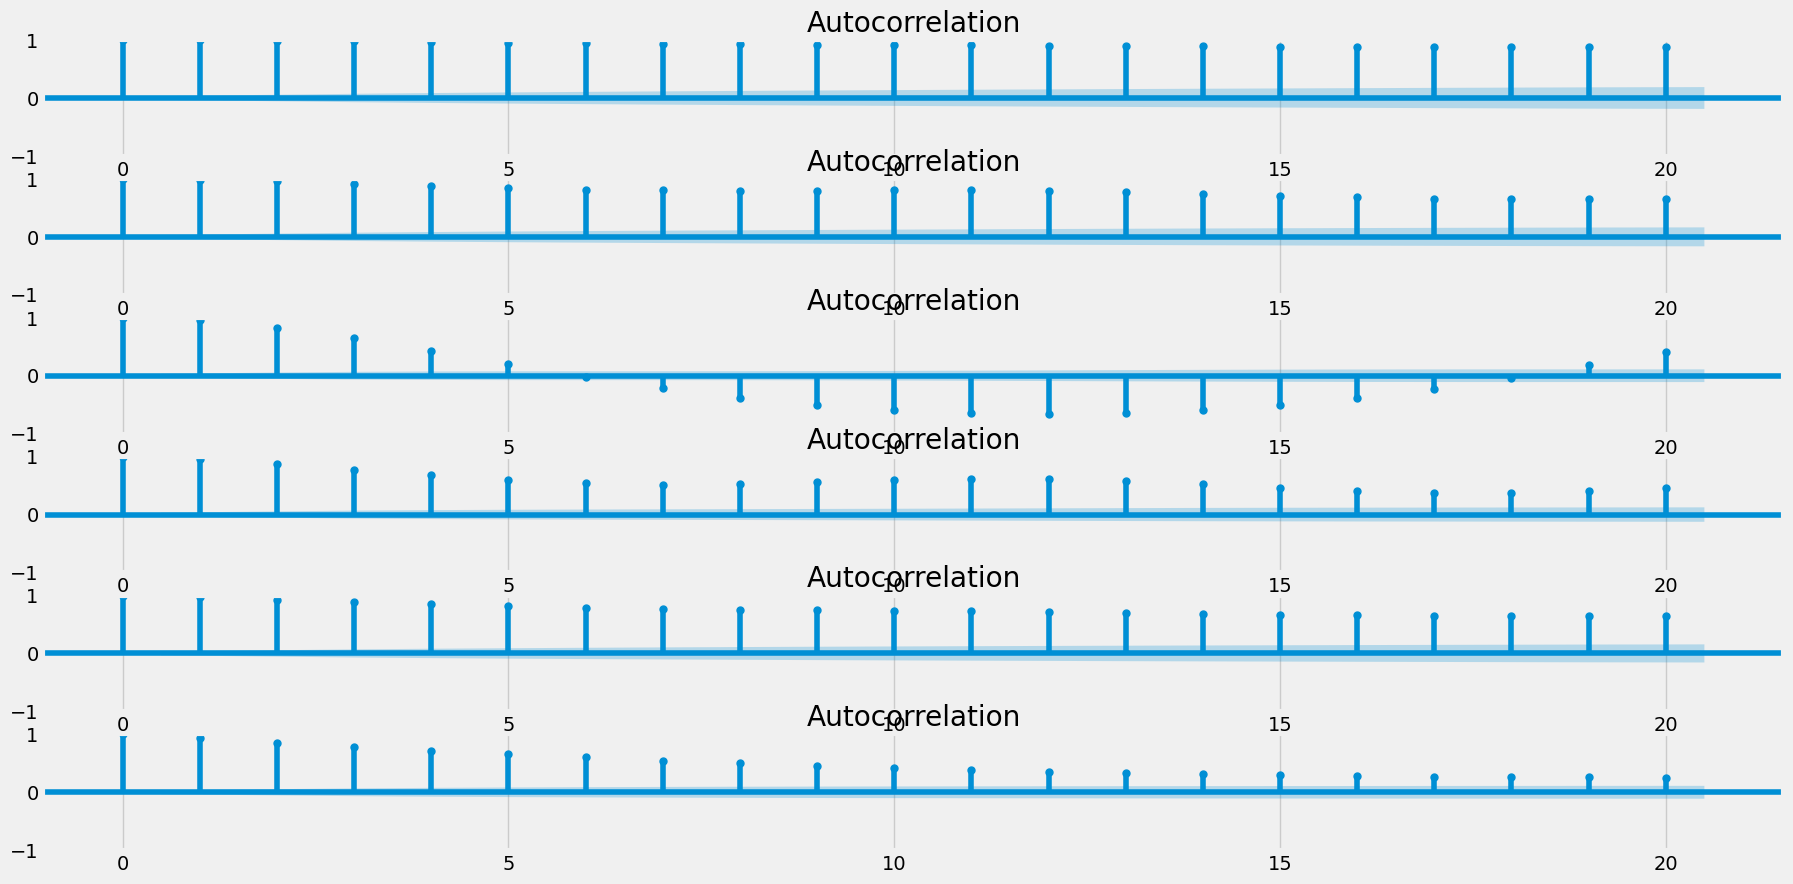

In [72]:
import statsmodels as sm 
from statsmodels.graphics import tsaplots # For the autocorrelation plot 

fig, axes = plt.subplots(6,1,figsize = (20,10))
fig = tsaplots.plot_acf(PCA_Dataset[PCA_Dataset.columns[0]], lags= 20, ax=axes[0])
fig = tsaplots.plot_acf(PCA_Dataset[PCA_Dataset.columns[1]], lags= 20, ax=axes[1])
fig = tsaplots.plot_acf(PCA_Dataset[PCA_Dataset.columns[2]], lags= 20, ax=axes[2])
fig = tsaplots.plot_acf(PCA_Dataset[PCA_Dataset.columns[3]], lags= 20, ax=axes[3])
fig = tsaplots.plot_acf(PCA_Dataset[PCA_Dataset.columns[4]], lags= 20, ax=axes[4])
fig = tsaplots.plot_acf(PCA_Dataset[PCA_Dataset.columns[5]], lags= 20, ax=axes[5])

# On the previous graph we see that the autocorrelation of the 4th feature is low after 6 lags, I then choose to take 6 lags as a treshold. 
# You will find this treshold named n_steps in the defined function for the data preparation. 

In [75]:
# Lets now create an LSTM neural network to forecast the electricity prices : 
# Importation of the libraries:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Now I setup the dataset into an array sequences and then I stack them Horizontaly: 

# Input sequence for Electricty price:
# Basicaly all the keeped features : 
in_seq1 = array(PCA_Dataset_train["PCA1"])
in_seq2 = array(PCA_Dataset_train["PCA2"])
in_seq3 = array(PCA_Dataset_train["PCA3"])
in_seq4 = array(PCA_Dataset_train["PCA4"])
in_seq5 = array(PCA_Dataset_train["PCA5"])
in_seq6 = array(PCA_Dataset_train["PCA6"])
in_seq7 = array(PCA_Dataset_train["price"])

# The Price to forecast : 
out_seq1 = array(PCA_Dataset_train["Price_to_forecast"])

# Convert to [rows, columns] structure : 
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))

out_seq1 = out_seq1.reshape((len(out_seq1), 1))

# Horizontal stacking of the columns : 
stacked_dataset= hstack((in_seq1,in_seq2,in_seq3,in_seq4,in_seq5,in_seq6,in_seq7,out_seq1))
# Basically, stacked_dataset is created to being able to pass it throw the LSTM network. 

# Lets now define a couple of function to perform the training, testing and predict the two remaining months of Electricity prices : 

In [78]:
# This function cut the constructed DataFrame into a list of sub_DataFrames, we can choose the lenght of the sub_DataFrames,
# This lenght correspond to the rolling_window on wich we want to train the model. 
# For example, if we choose n_steps = 10, the algorithm will learn to give the value of the price a T+1 based on the value of the feature going from T-10 to T.
# Input : DataFrame,int
# Output : Array_feature, Array_target
def split_sequences(sequences,n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# This function calcul de Mean Square Error between two series: 
# Input : Serie1,Serie2
# Output : Float(MSE(Serie1,Serie2))
def get_MSE(real_value,predicted_value):
    
    MSE = mean_squared_error(real_value,predicted_value)
    
    return MSE

In [205]:
# Now that I have a ready to use dataset for forecasting the Electricity prices,
# I split this dataset into a training and a testing one to get performance metrics on the models before using the best one to forecast the 2 remaining months (May and June 2022).
# Training and Testing datasets: 
training_dataset = stacked_dataset[:int(len(stacked_dataset)*0.8)]
test_dataset = stacked_dataset[int(len(stacked_dataset)*0.8):]
n_steps = 6
# Getting the Window_lenght_sequences:
X_train, y_train = split_sequences(training_dataset, n_steps)
X_test, y_test = split_sequences(test_dataset, n_steps)

In [207]:
# List of activation function:
activation_function_list = ["relu","sigmoid","linear","tanh","softmax","leaky_relu"]

# This Function create an LSTM neural network for various activation function : 
# Input : activation_function : string
# Output : model (neural network)
def Define_model(activation): 
    
    model = Sequential()
    model.add(LSTM(100, activation=activation, return_sequences=True, input_shape=(n_steps,
                                                                               7)))
    model.add(LSTM(100, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    return model 

# This function is the LSTM Pipeline:
# Input : Activation_function_list : string_list,n_steps : Int 
# Output : Predicted_prices_list,Train_MSE_list,Test_MSE_list
def get_results_for_various_activation_function(activation_function_list):
    # List to append the trained models,MSE_Train,MSE_TEst and pred_values for each activation funtion :
    model_list = []
    MSE_train_list = []
    MSE_test_list = []
    reversed_value_list = []

    for value in activation_function_list:

         # WE can now work with the obtained value to calcul Mean_Square_error on the train and test dataframe.
         # Creation of the model: 
        model = Define_model(value)

            # Fit the model:
        model.fit(X_train, y_train, epochs=40, verbose=0)
        model_list.append(model)

        # Now that the model is fitted, we want him to predict each of the value on the training dataset:
        predicted_values = []

        for i in range (len(X_train)):
            x_input = []
            for k in range (n_steps):
                x_input.append([X_train[i][k]])

            x_input = array(x_input)
            x_input = x_input.reshape((n_steps,1,7))
            x_input = x_input.reshape((1, n_steps, 7))
            predicted_values.append(float(model.predict(x_input, verbose=0)))

            # Now we use the test_dataset to predict the value with the trained model: 
        for i in range (len(X_test)):
            x_input = []

            for k in range (n_steps):
                x_input.append([X_test[i][k]])

            x_input = array(x_input)
            x_input = x_input.reshape((n_steps,1,7))
            x_input = x_input.reshape((1, n_steps, 7))
            predicted_values.append(float(model.predict(x_input, verbose=0)))    

        # WE can now work with the obtained value to calcul Mean_Square_error on the train and test dataframe.

        value_predicted = pd.DataFrame(predicted_values)

        value_predicted = pd.DataFrame(predicted_values)

        pred_train = value_predicted[:len(X_train)]
        pred_test = value_predicted[len(X_train):]

        train_list = list(scaled_dataset_pred[:5].price_to_forecast)
        test_list = list(scaled_dataset_pred[len(X_train):len(X_train)+5].price_to_forecast)

        for value in pred_train.values:
            train_list.append(value[0])

        for value in pred_test.values:
            test_list.append(value[0])

        final_predicted_ajusted_list  = pd.concat([pd.DataFrame(train_list),pd.DataFrame(test_list)])
        reverse_scaled_results = pd.DataFrame(scaler_pred.inverse_transform(final_predicted_ajusted_list))

        MSE_train = get_MSE(target_dataframe[:len(X_train)],reverse_scaled_results[:len(X_train)])
        MSE_test = get_MSE(target_dataframe[len(X_train):],reverse_scaled_results[len(X_train):])

        reversed_value_list.append(reverse_scaled_results) 
        MSE_train_list.append(MSE_train)
        MSE_test_list.append(MSE_test)
        
    return reversed_value_list,MSE_train_list,MSE_test_list,model_list

In [208]:
# Lets now get the results:
Predicted_value_list,MSE_train_list,MSE_test_list,model_list = get_results_for_various_activation_function(activation_function_list)

In [210]:
# And aggregate them into a DataFrame: 
results = pd.concat([pd.DataFrame(MSE_train_list),pd.DataFrame(MSE_test_list)],axis=1)
results.index = activation_function_list
results.columns = ["Train MSE","Test MSE"]
results["Overfitting Index % "] = 100 * np.abs(1 - results["Test MSE"]/results["Train MSE"] )
results

,Train MSE,Test MSE,Overfitting Index %
relu,587.697430,1523.034567,159.152838
sigmoid,379.530690,539.706632,42.203686
linear,482.716980,494.087520,2.355529
tanh,600.474375,630.254670,4.959461
softmax,7441.065891,2340.850804,68.541458
leaky_relu,533.346209,992.077369,86.010016


# As you can see on the previous table, the model who have the lowest overfitting Index is the one that use a linear activation function.
# So I'm going to use this one to predict the Day Ahead prices. 

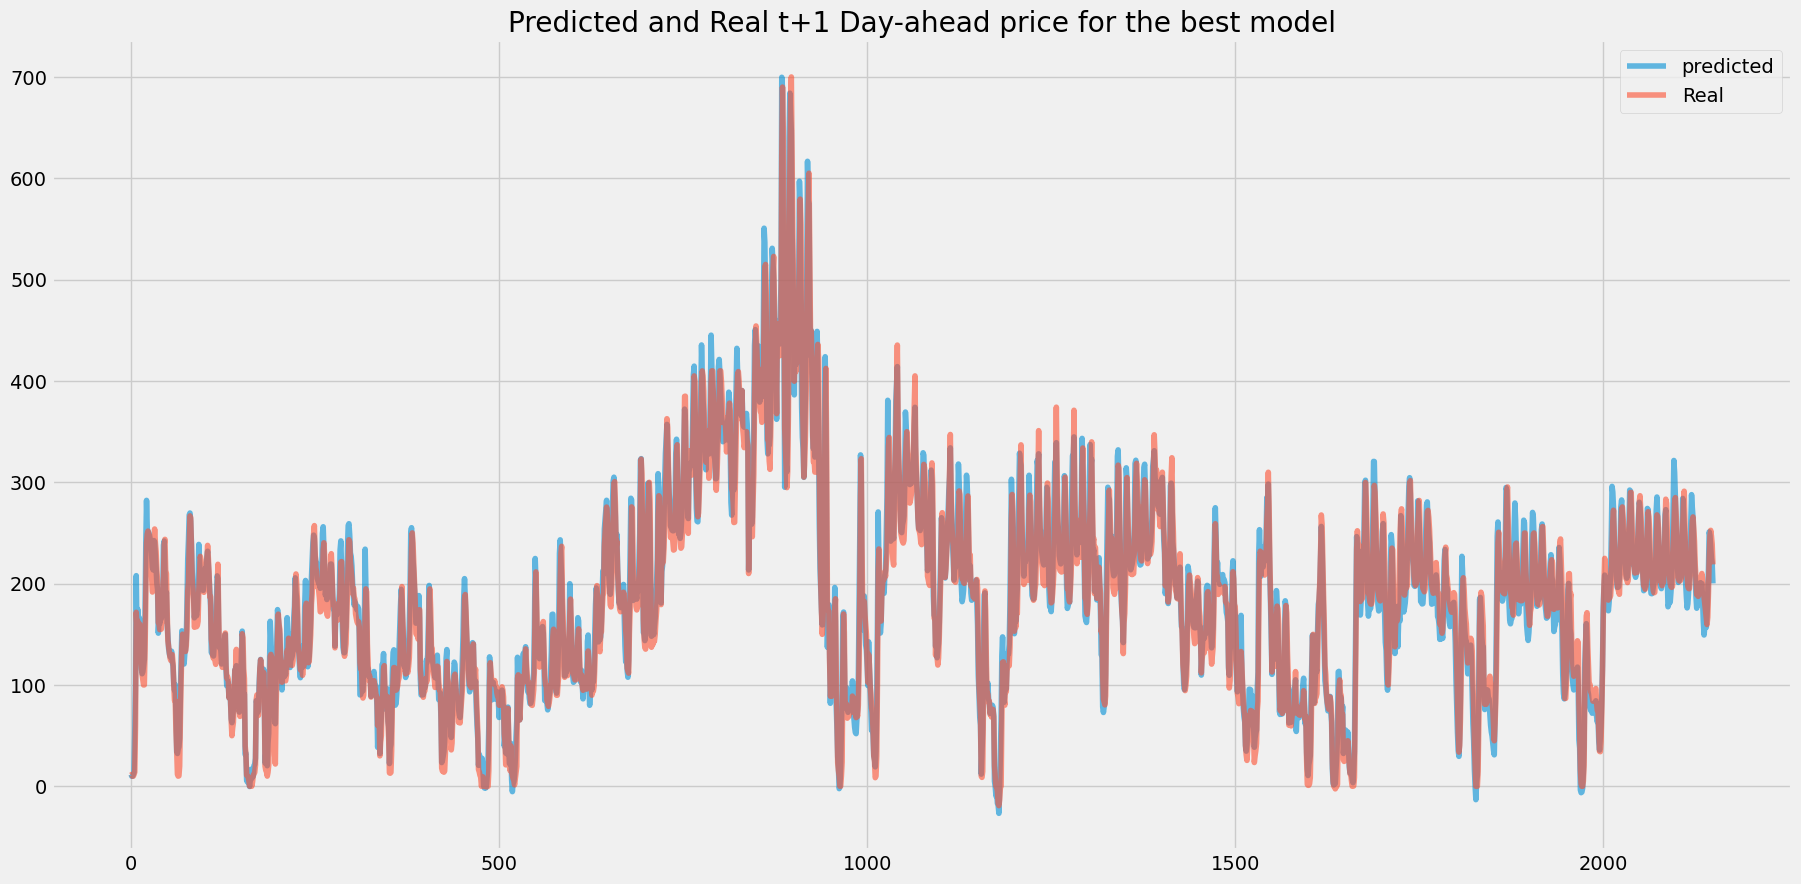

In [215]:
# 3 months real and forecasted:
plt.figure(figsize = (20,10))
plt.plot(Predicted_value_list[2].values,alpha = 0.6,label = "predicted")
plt.plot(target_dataframe.values,alpha = 0.6,label = "Real")
plt.title("Predicted and Real t+1 Day-ahead price for the best model")
plt.legend()

C:\Users\victo\AppData\Local\Temp\ipykernel_19844\1073123817.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Predicted_value_list[2].values.min(), Predicted_value_list[2].values.max()], [Predicted_value_list[2].values.min(), Predicted_value_list[2].values.max()], 'k--', lw=2, color='red')


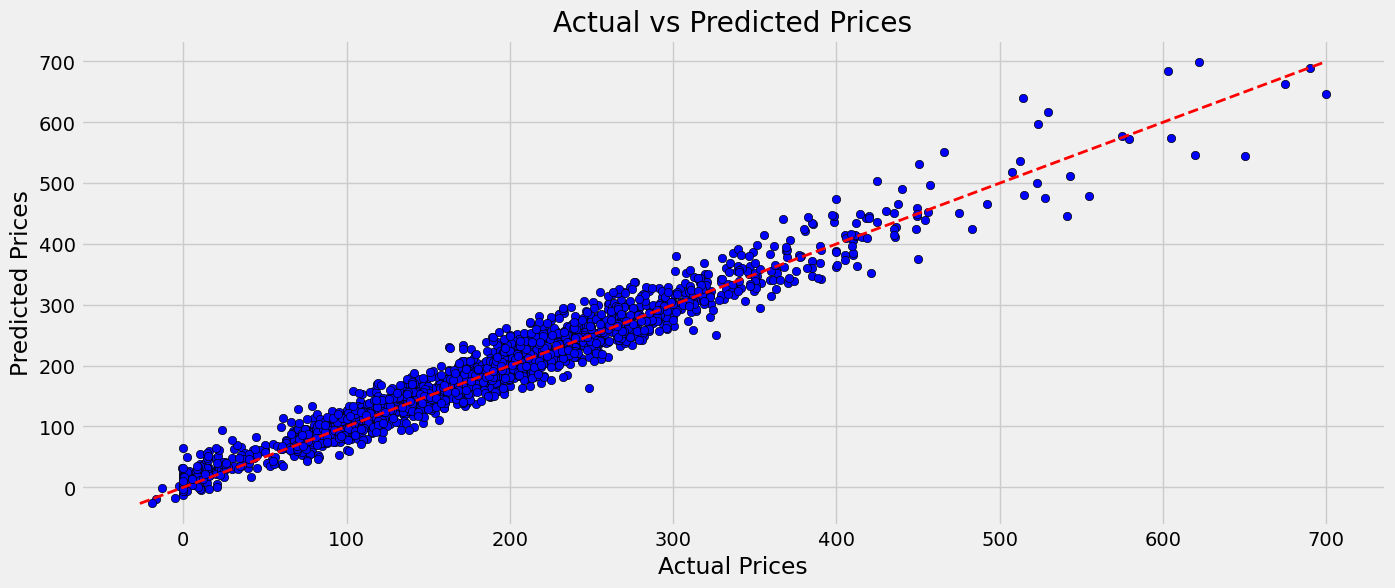

In [219]:
plt.figure(figsize=(15, 6))
plt.scatter(target_dataframe.values, Predicted_value_list[2].values, color='blue', edgecolors='k')
plt.plot([Predicted_value_list[2].values.min(), Predicted_value_list[2].values.max()], [Predicted_value_list[2].values.min(), Predicted_value_list[2].values.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

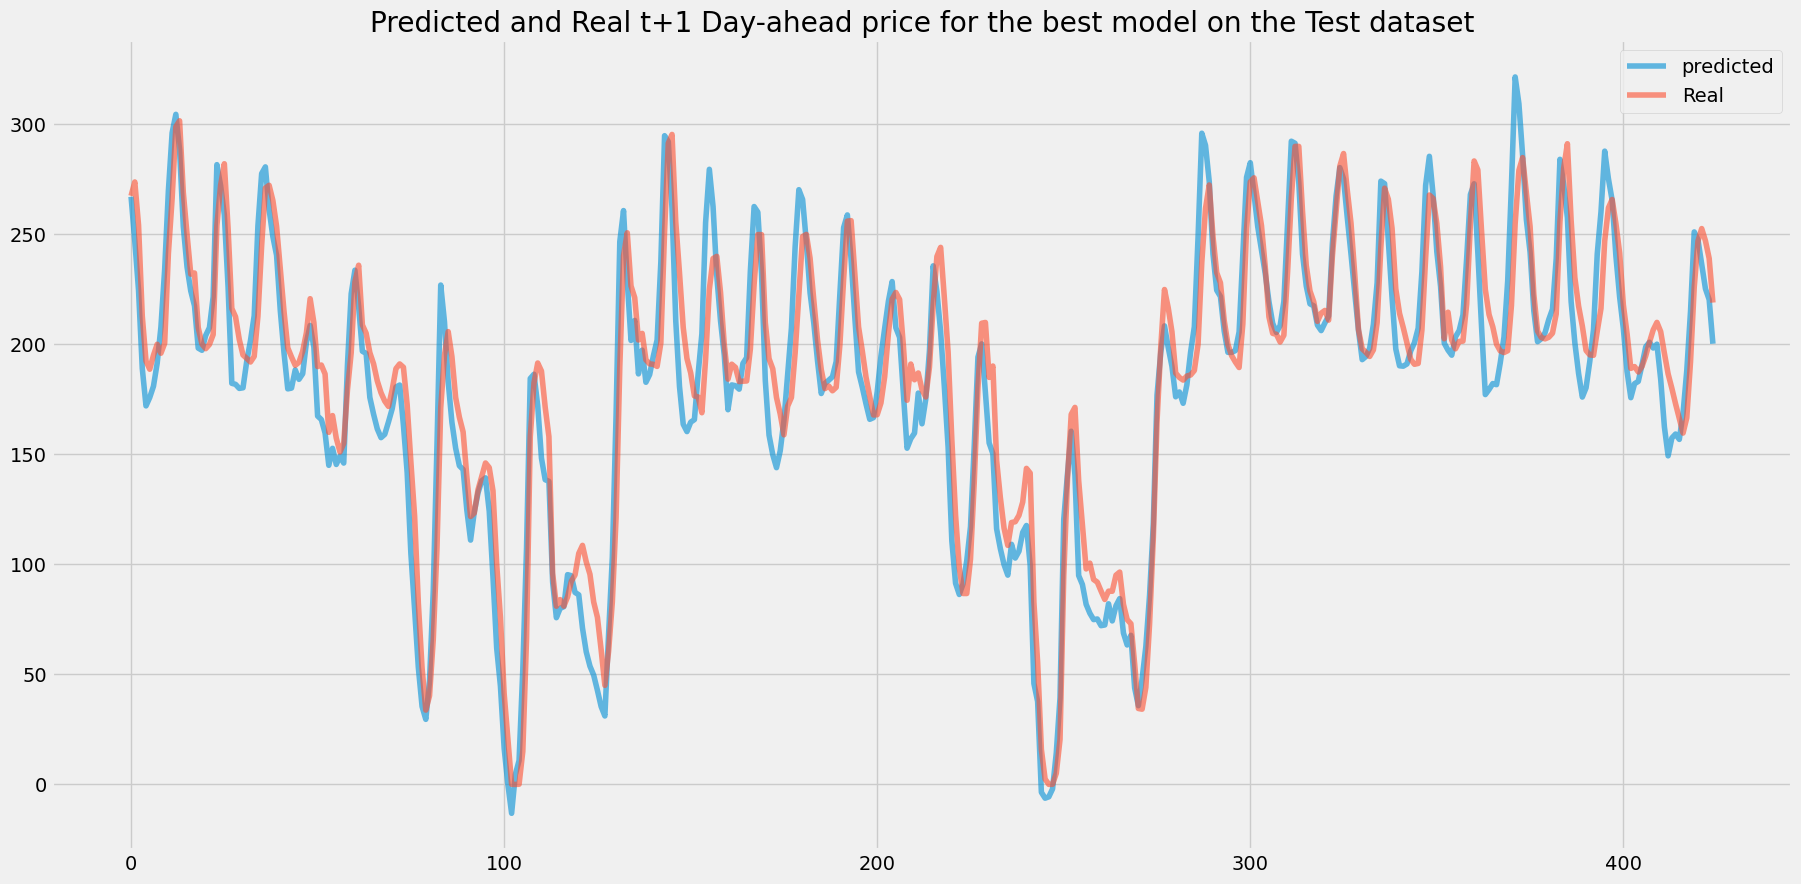

In [221]:
# Test real and forecated :
plt.figure(figsize = (20,10))
plt.plot(Predicted_value_list[2].values[-len(X_test):],alpha = 0.6,label = "predicted")
plt.plot(target_dataframe.values[-len(X_test):],alpha = 0.6,label = "Real")
plt.title("Predicted and Real t+1 Day-ahead price for the best model on the Test dataset")
plt.legend()

In [223]:
X_train,y_train = split_sequences(stacked_dataset,n_steps)

# We see that the best result is obtained with the linear activation function. 
# I then will train this model on the whole dataset and use it to forecast the Electricty price for May and June 2022.

# Creation of the model: 
model = model_list[2]
# Fit the model on the whole dataset:
model.fit(X_train[:-1], y_train[:-1], epochs=40, verbose=0)

In [224]:
PCA_Dataset_test = PCA_Dataset_test.copy()
PCA_Dataset_test['price'] = np.nan
Previous_PCA_Dataset_to_append = PCA_Dataset_train[-n_steps:][PCA_Dataset_train[-n_steps:].columns[:-1]]
Previous_PCA_Dataset_to_append

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,price
2144,0.222841,-0.279152,-0.126297,-0.318792,0.207206,0.023165,0.340913
2145,0.194921,-0.309341,-0.207041,-0.324819,0.179672,0.079721,0.369952
2146,0.168566,-0.306312,-0.252439,-0.356378,0.160032,0.105039,0.377837
2147,0.137025,-0.285290,-0.261526,-0.398421,0.143090,0.117778,0.370146
2148,0.137015,-0.265500,-0.276061,-0.435971,0.145103,0.117807,0.358993
2149,0.127396,-0.228094,-0.293537,-0.511418,0.129914,0.115763,0.331053


In [225]:
final_dataset_to_predict = pd.concat([Previous_PCA_Dataset_to_append,PCA_Dataset_test])
final_dataset_to_predict.reset_index(inplace = True)
final_dataset_to_predict.drop(columns = "index",inplace = True)
final_dataset_to_predict

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,price
0,0.222841,-0.279152,-0.126297,-0.318792,0.207206,0.023165,0.340913
1,0.194921,-0.309341,-0.207041,-0.324819,0.179672,0.079721,0.369952
2,0.168566,-0.306312,-0.252439,-0.356378,0.160032,0.105039,0.377837
3,0.137025,-0.285290,-0.261526,-0.398421,0.143090,0.117778,0.370146
4,0.137015,-0.265500,-0.276061,-0.435971,0.145103,0.117807,0.358993
...,...,...,...,...,...,...,...
1465,0.457570,-0.311403,0.000592,0.339022,0.336607,-0.067809,NaN
1466,0.432612,-0.302979,-0.094779,0.347809,0.343039,-0.071415,NaN
1467,0.356589,-0.265646,-0.162937,0.356648,0.310722,-0.104796,NaN
1468,0.280155,-0.215956,-0.178881,0.289299,0.289736,-0.042944,NaN


In [229]:
# I setup one more time the dataset into an array sequences and then I stack them Horizontaly: 
# Input sequence for Electricty price:
# Basicaly all the keeped features : 
in_seq1 = array(final_dataset_to_predict["PCA1"])
in_seq2 = array(final_dataset_to_predict["PCA2"])
in_seq3 = array(final_dataset_to_predict["PCA3"])
in_seq4 = array(final_dataset_to_predict["PCA4"])
in_seq5 = array(final_dataset_to_predict["PCA5"])
in_seq6 = array(final_dataset_to_predict["PCA6"])

# The Price to forecast : 
out_seq1 = array(final_dataset_to_predict["price"])

# Convert to [rows, columns] structure : 
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))

out_seq1 = out_seq1.reshape((len(out_seq1), 1))

# Horizontal stacking of the columns : 
stacked_dataset_forecast = hstack((in_seq1,in_seq2,in_seq3,in_seq4,in_seq5,in_seq6,out_seq1))

In [231]:
# This function get the predicted results:
# Input : DataFrame
# Output : DataFrame
def get_predicted_results(dataset):
    start = 0 
    end = n_steps
    
    for k in range(len(dataset)-n_steps+1):

        if k ==0:

            sub_data = dataset[start:end]
            sub_data = sub_data.reshape(1,6,7)
            pred = float(model.predict(sub_data, verbose=0))
            start +=1
            end +=1

        if k > 0: 

            sub_data = dataset[start:end]
            sub_data[-1][-1] = pred
            sub_data = sub_data.reshape(1,6,7)
            pred = float(model.predict(sub_data, verbose=0))

            start +=1
            end +=1
            
    return dataset

In [233]:
# The results:
stacked_dataset_forecast = get_predicted_results(stacked_dataset_forecast)

In [234]:
# Now I work with the obtained results : 
# Some precise manipulation to obtain the previously missed price values : 
pred_prices = pd.DataFrame(stacked_dataset_forecast)[6][n_steps-1:]

list_result = []
scaled_price = list(scaled_dataset_pred.price)
for value in pred_prices[1:]:
    scaled_price.append(value)
scaled_price = pd.DataFrame(scaled_price)

In [235]:
reverse_scaled_dataset_pred = pd.DataFrame(scaler_pred.inverse_transform(scaled_price))
reverse_scaled_dataset_pred.columns = ["price"]

reverse_scaled_dataset_feature = pd.DataFrame(scaler_feature.inverse_transform(scaled_dataset_feature))
reverse_scaled_dataset_feature.columns = scaled_dataset_feature.columns
Final_DataFrame = pd.concat([reverse_scaled_dataset_feature,reverse_scaled_dataset_pred], axis = 1)
Final_DataFrame.index = feature_dataframe.index

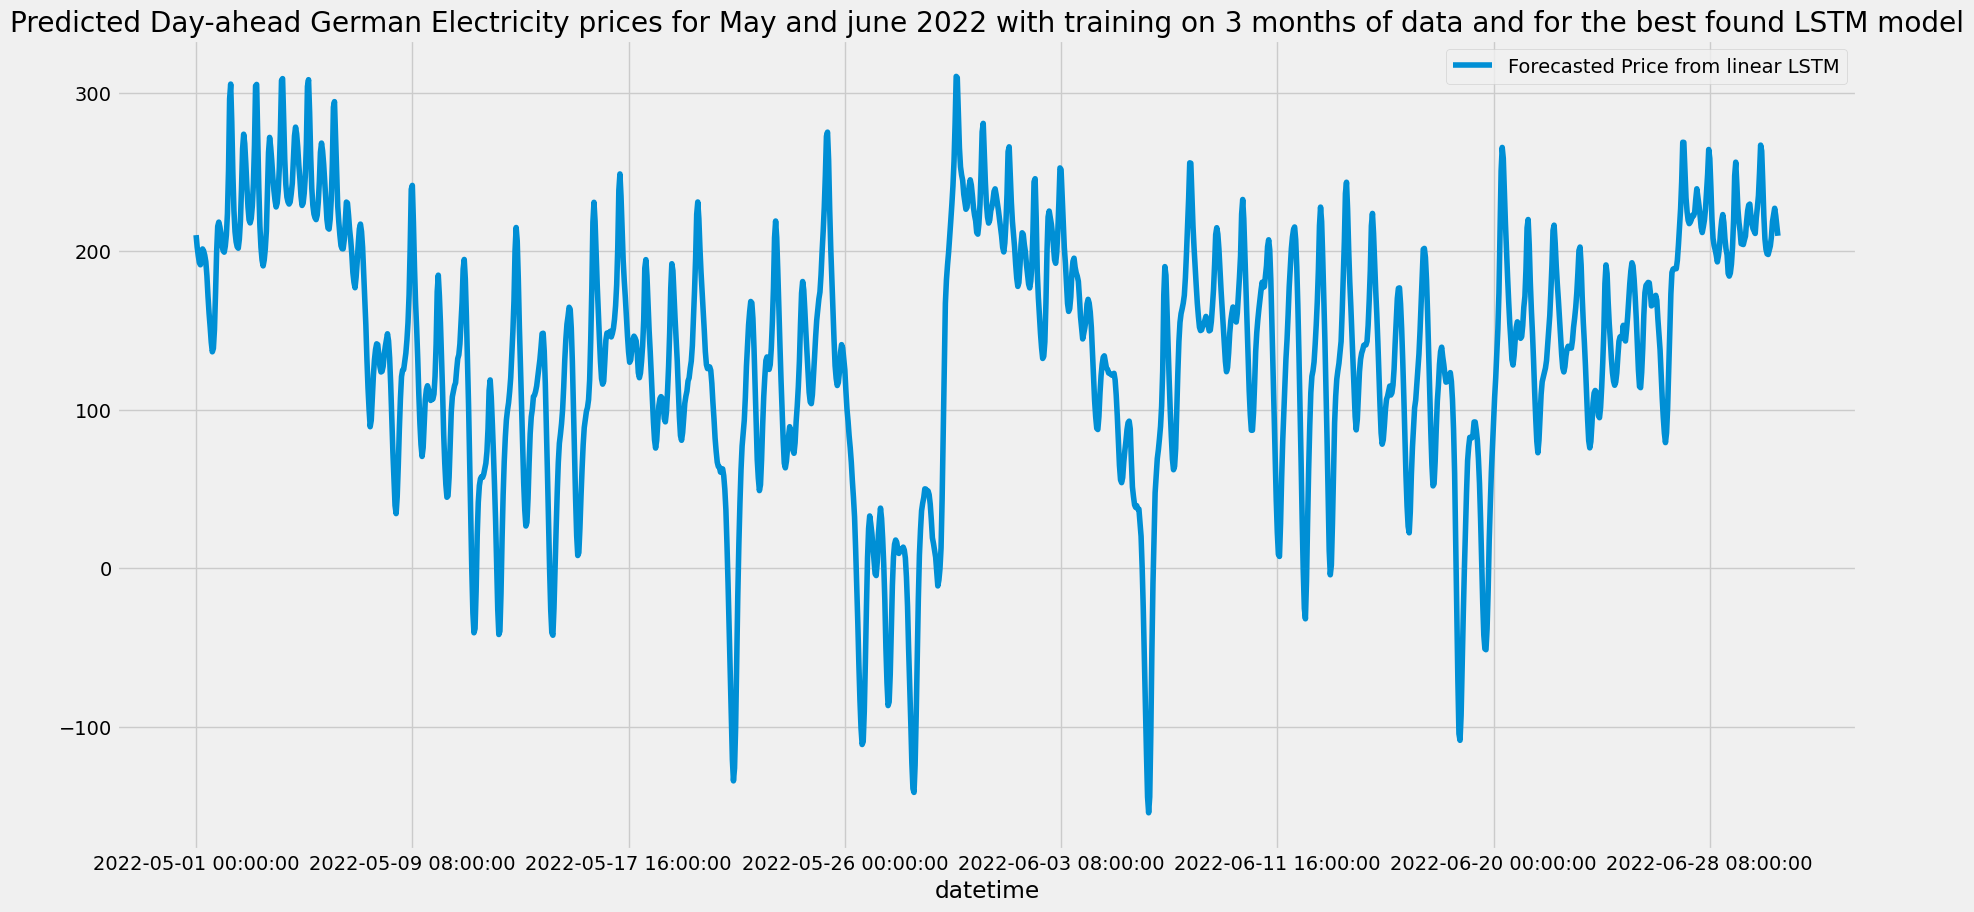

In [236]:
# Lets see the forecasted price for May and June:
Final_DataFrame["price"][-lenght_may_june_price:].plot(figsize = (20,10),label = "Forecasted Price from linear LSTM")
plt.title("Predicted Day-ahead German Electricity prices for May and june 2022 with training on 3 months of data and for the best found LSTM model")
plt.legend()

In [241]:
# Writing the results to a csv file :
Final_DataFrame["price"][-lenght_may_june_price:].to_csv("Price_May_June_3_months_linear.csv")